# First Architecture

This is a simple perceptron architecture with only one layer.

In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

## Load Data

In [3]:
df_train = pd.read_csv('data/raw/lithology.csv', sep=';')
df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


In [4]:
def lithology_number_to_name(x):
    if x == 30000.0:
        return 'Sandstone'
    elif x == 65030.0:
        return 'Sandstone/Shale'
    elif x == 65000.0:
        return 'Shale'
    elif x == 80000.0:
        return 'Marl'
    elif x == 74000.0:
        return 'Dolomite'
    elif x == 70000.0:
        return 'Limestone'
    elif x == 70032.0:
        return 'Chalk'
    elif x == 88000.0:
        return 'Halite'
    elif x == 86000.0:
        return 'Anhydrite'
    elif x == 99000.0:
        return 'Tuff'
    elif x == 90000.0:
        return 'Coal'
    elif x == 93000.0:
        return 'Basement'
    else: raise ValueError('Category Not Found')

df_train = df_train.assign(FORCE_2020_LITHOFACIES_LITHOLOGY_CAT = df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.apply(lambda x: lithology_number_to_name(x)))

df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [5]:
df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [6]:
def get_values_from_category(df_train, n_samples=1000):
    '''
    Get the same values (or all if it has less than) of all categories. The idea is to balance dataset
    '''

    df_data = pd.DataFrame()

    for cat in df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.unique():
        df_data = df_data.append(df_train[df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT == cat].iloc[0:n_samples])
    
    return df_data

In [7]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

def transform_data(X_train, X_test, X_val, y_train, y_test, y_val):
    scl = MinMaxScaler()
    oe = OrdinalEncoder()

    X_train_transform = scl.fit_transform(X_train)
    X_test_transform = scl.transform(X_test)
    X_val_transform = scl.transform(X_val)

    y_train_enc = oe.fit_transform(y_train)
    y_test_enc = oe.transform(y_test)
    y_val_enc = oe.transform(y_val)

    return X_train_transform, X_test_transform, X_val_transform, y_train_enc, y_test_enc, y_val_enc

In [8]:
def get_class_distribution(obj):
    count_dict = {
        'Anhydrite': 0, 
        'Basement': 0, 
        'Chalk': 0, 
        'Coal': 0, 
        'Dolomite': 0, 
        'Halite': 0,
        'Limestone': 0, 
        'Marl': 0, 
        'Sandstone': 0, 
        'Sandstone/Shale': 0, 
        'Shale': 0,
        'Tuff': 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Anhydrite'] += 1
        elif i == 1: 
            count_dict['Basement'] += 1
        elif i == 2: 
            count_dict['Chalk'] += 1
        elif i == 3: 
            count_dict['Coal'] += 1
        elif i == 4: 
            count_dict['Dolomite'] += 1  
        elif i == 5: 
            count_dict['Halite'] += 1
        elif i == 6: 
            count_dict['Limestone'] += 1                    
        elif i == 7: 
            count_dict['Marl'] += 1
        elif i == 8: 
            count_dict['Sandstone'] += 1
        elif i == 9: 
            count_dict['Sandstone/Shale'] += 1
        elif i == 10: 
            count_dict['Shale'] += 1
        elif i == 11: 
            count_dict['Tuff'] += 1
        else:
            print("Check classes.")
            
    return count_dict

### Architectures To Evaluate

In [9]:
#single_layer
class SingleLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(SingleLayerSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

# multi_layer
class MultiLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_out(x)
        return x

# multi_layer_relu
class MultiLayerReLUSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerReLUSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.relu(x)

        x = self.layer_out(x)
        return x

# multi_layer_relu_batch_norm
class MultiLayerReLUBatchNormSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerReLUBatchNormSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        
        self.relu = nn.ReLU()
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.batch_norm_2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)

        x = self.layer_out(x)
        return x

# multi_layer_relu_batch_norm_dropout
class MultiLayerReLUBatchNormDropoutSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(MultiLayerReLUBatchNormDropoutSoftmax, self).__init__()
        self.layer_1 = nn.Linear(n_input, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.batch_norm_2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        return x

In [10]:
def load_model(model_name, num_features, num_classes):
    if model_name == 'single_layer':
        return SingleLayerSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer':
        return MultiLayerSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_relu':
        return MultiLayerReLUSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_relu_batch_norm':
        return MultiLayerReLUBatchNormSoftmax(num_features, num_classes)
    elif model_name == 'multi_layer_relu_batch_norm_dropout':
        return MultiLayerReLUBatchNormDropoutSoftmax(num_features, num_classes)

### Creating a simple model

Model created thanks to this documentation: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [11]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

def fit_model(
    X_train, y_train, X_test, y_test, X_val, y_val, 
    epochs=5, batch_size=16, num_classes=12, learning_rate=0.05,
    model_name='single_layer'
):
    NUM_FEATURES = len(X.columns)
    NUM_CLASSES = 12

    train_dataset = ClassifierDataset(
        torch.from_numpy(X_train.astype(np.float32)), 
        torch.from_numpy(y_train.reshape(-1)).long()
    )

    val_dataset = ClassifierDataset(
        torch.from_numpy(X_val.astype(np.float32)), 
        torch.from_numpy(y_val.reshape(-1)).long()
    )

    test_dataset = ClassifierDataset(
        torch.from_numpy(X_test.astype(np.float32)), 
        torch.from_numpy(y_test.reshape(-1)).long()
    )

    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]

    # Due to unbalanced data, create weights to classes
    class_count = [i for i in get_class_distribution(y_train).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float)

    class_weights_all = class_weights[target_list]
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=weighted_sampler
    )

    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = load_model(model_name, NUM_FEATURES, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(model)

    accuracy_stats = {
        'train': [],
        'val': []
    }

    loss_stats = {
        'train': [],
        'val': []
    }

    print('Begin training')

    # Using tqdm to show the loading
    for e in tqdm(range(1, epochs+1)):
        # Training
        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        
        # Validation
        with torch.no_grad():
            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:

                y_val_pred = model(X_val_batch)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        
        train_loss = train_epoch_loss/len(train_loader)
        val_loss = val_epoch_loss/len(val_loader)

        train_acc = train_epoch_acc/len(train_loader)
        val_acc = val_epoch_acc/len(val_loader)

        loss_stats['train'].append(train_loss)
        loss_stats['val'].append(val_loss)
        accuracy_stats['train'].append(train_acc)
        accuracy_stats['val'].append(val_acc)
        print(f'''Epoch {e+0:03}: | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | 
        Train Acc: {train_acc:.3f}% | Val Acc: {val_acc:.3f}%''')

    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index": "epochs"})

    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index": "epochs"})

    # Plotting Accuracy and Loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x='epochs', y='value', hue='variable', ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x='epochs', y='value', hue='variable', ax=axes[1]).set_title('Train-Val Loss/Epoch')

    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim=1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    idx2class = {
        0: 'Anhydrite', 
        1: 'Basement', 
        2: 'Chalk', 
        3: 'Coal', 
        4: 'Dolomite', 
        5: 'Halite',
        6: 'Limestone', 
        7: 'Marl', 
        8: 'Sandstone', 
        9: 'Sandstone/Shale', 
        10: 'Shale',
        11: 'Tuff'
    }

    # Confusion Matrix
    # ax = plt.subplot()
    plt.figure()
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
    # sns.heatmap(confusion_matrix_df, annot=True, fmt='g', ax=ax)
    sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

    print(classification_report(y_test, y_pred_list))

    return model

### Test 1

Chalk              10000
Sandstone          10000
Marl               10000
Tuff               10000
Sandstone/Shale    10000
Limestone          10000
Shale              10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
SingleLayerSoftmax(
  (Linear): Linear(in_features=30, out_features=12, bias=True)
)
Begin training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.10713 | Val Loss: 0.88771 | 
        Train Acc: 67.258% | Val Acc: 73.465%
Epoch 002: | Train Loss: 0.84442 | Val Loss: 0.85061 | 
        Train Acc: 73.563% | Val Acc: 72.766%
Epoch 003: | Train Loss: 0.80407 | Val Loss: 0.80036 | 
        Train Acc: 73.689% | Val Acc: 73.664%
Epoch 004: | Train Loss: 0.77275 | Val Loss: 0.77633 | 
        Train Acc: 74.749% | Val Acc: 74.658%
Epoch 005: | Train Loss: 0.75247 | Val Loss: 0.77768 | 
        Train Acc: 74.870% | Val Acc: 74.533%
Epoch 006: | Train Loss: 0.74673 | Val Loss: 0.75088 | 
        Train Acc: 74.957% | Val Acc: 76.461%
Epoch 007: | Train Loss: 0.73087 | Val Loss: 0.74123 | 
        Train Acc: 75.250% | Val Acc: 74.709%
Epoch 008: | Train Loss: 0.72551 | Val Loss: 0.72202 | 
        Train Acc: 75.089% | Val Acc: 74.960%
Epoch 009: | Train Loss: 0.72824 | Val Loss: 0.76416 | 
        Train Acc: 75.066% | Val Acc: 74.062%
Epoch 010: | Train Loss: 0.71155 | Val Loss: 0.75655 | 
        Train Acc: 75.562%

SingleLayerSoftmax(
  (Linear): Linear(in_features=30, out_features=12, bias=True)
)

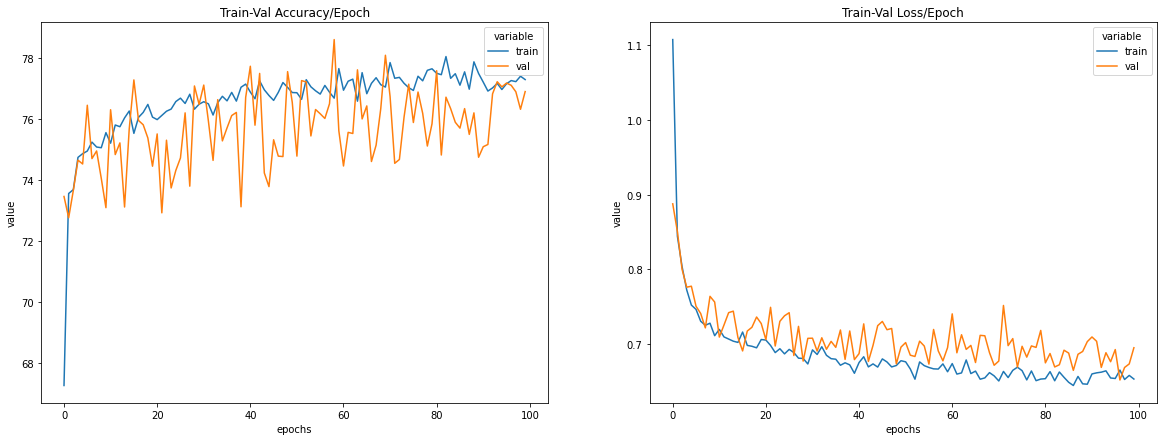

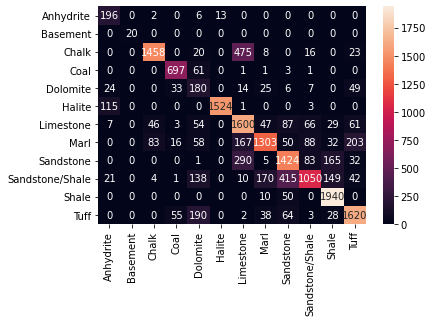

In [12]:
df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=100, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='single_layer'
)

### Test 2

Tuff               10000
Limestone          10000
Chalk              10000
Sandstone/Shale    10000
Shale              10000
Sandstone          10000
Marl               10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayerSoftmax(
  (layer_1): Linear(in_features=30, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
)
Begin training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.19737 | Val Loss: 0.88155 | 
        Train Acc: 61.386% | Val Acc: 68.703%
Epoch 002: | Train Loss: 1.03517 | Val Loss: 1.10675 | 
        Train Acc: 66.752% | Val Acc: 59.789%
Epoch 003: | Train Loss: 1.03587 | Val Loss: 1.16209 | 
        Train Acc: 67.064% | Val Acc: 62.005%
Epoch 004: | Train Loss: 0.94108 | Val Loss: 0.93240 | 
        Train Acc: 68.710% | Val Acc: 64.736%
Epoch 005: | Train Loss: 1.00365 | Val Loss: 0.82376 | 
        Train Acc: 69.045% | Val Acc: 73.222%
Epoch 006: | Train Loss: 0.94064 | Val Loss: 0.85371 | 
        Train Acc: 69.012% | Val Acc: 69.859%
Epoch 007: | Train Loss: 0.95682 | Val Loss: 0.95365 | 
        Train Acc: 68.970% | Val Acc: 70.102%
Epoch 008: | Train Loss: 0.99861 | Val Loss: 0.86800 | 
        Train Acc: 70.159% | Val Acc: 66.016%
Epoch 009: | Train Loss: 0.90953 | Val Loss: 0.92093 | 
        Train Acc: 70.200% | Val Acc: 72.737%
Epoch 010: | Train Loss: 0.92848 | Val Loss: 0.88152 | 
        Train Acc: 69.564%

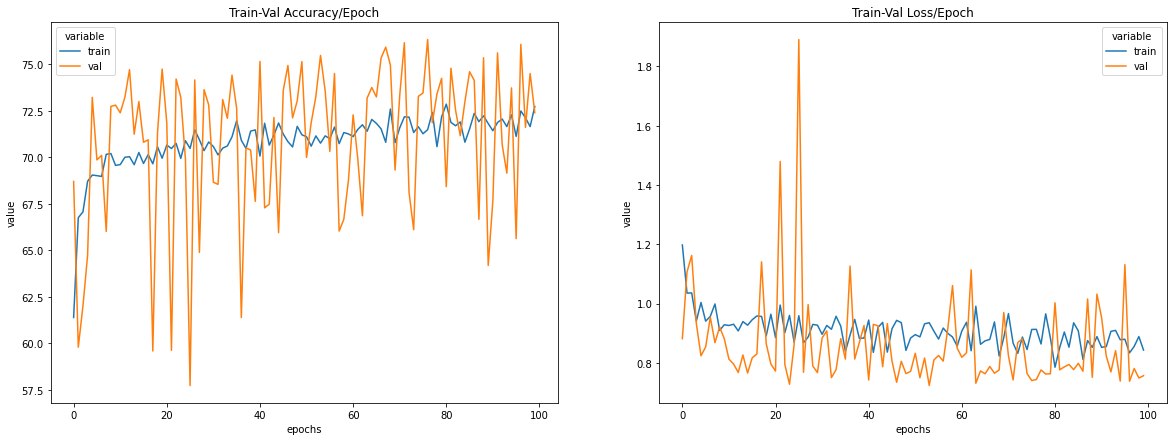

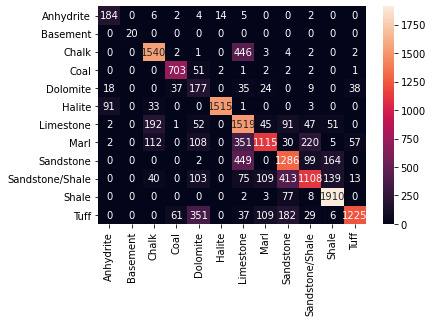

In [66]:
df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=100, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='multi_layer'
)

### Test 3

Limestone          50000
Sandstone/Shale    50000
Shale              50000
Sandstone          50000
Marl               33329
Tuff               15245
Chalk              10513
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayerSoftmax(
  (layer_1): Linear(in_features=30, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
)
Begin training


  0%|          | 0/1000 [00:00<?, ?it/s]

 1.08384 | 
        Train Acc: 59.453% | Val Acc: 63.830%
Epoch 814: | Train Loss: 1.15180 | Val Loss: 1.26604 | 
        Train Acc: 59.428% | Val Acc: 54.774%
Epoch 815: | Train Loss: 1.15533 | Val Loss: 1.06408 | 
        Train Acc: 59.482% | Val Acc: 63.198%
Epoch 816: | Train Loss: 1.11300 | Val Loss: 1.11309 | 
        Train Acc: 59.605% | Val Acc: 62.208%
Epoch 817: | Train Loss: 1.12000 | Val Loss: 1.13152 | 
        Train Acc: 59.524% | Val Acc: 59.724%
Epoch 818: | Train Loss: 1.13709 | Val Loss: 1.48091 | 
        Train Acc: 59.474% | Val Acc: 54.610%
Epoch 819: | Train Loss: 1.12659 | Val Loss: 1.97916 | 
        Train Acc: 59.609% | Val Acc: 49.254%
Epoch 820: | Train Loss: 1.15498 | Val Loss: 1.30381 | 
        Train Acc: 59.302% | Val Acc: 52.479%
Epoch 821: | Train Loss: 1.12700 | Val Loss: 1.06541 | 
        Train Acc: 59.152% | Val Acc: 64.297%
Epoch 822: | Train Loss: 1.14759 | Val Loss: 1.15265 | 
        Train Acc: 59.065% | Val Acc: 61.063%
Epoch 823: | Train Loss:

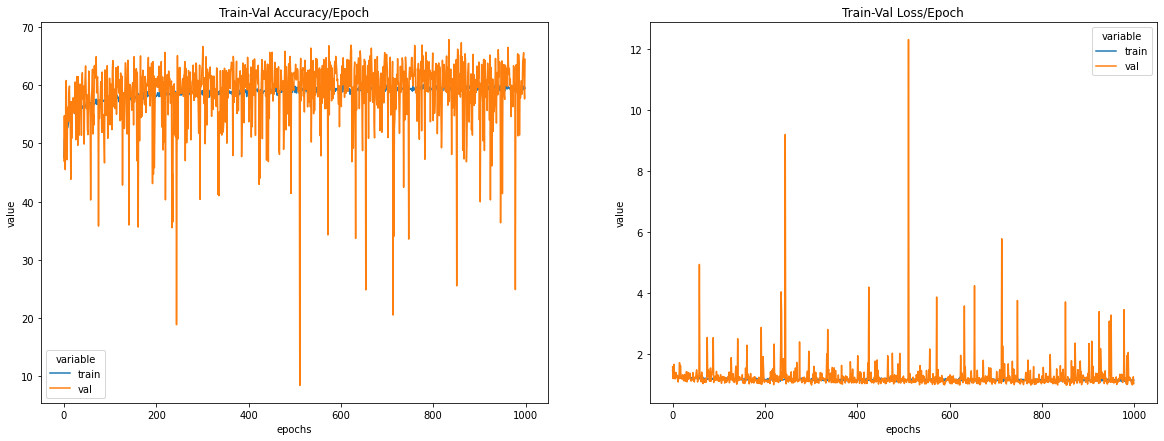

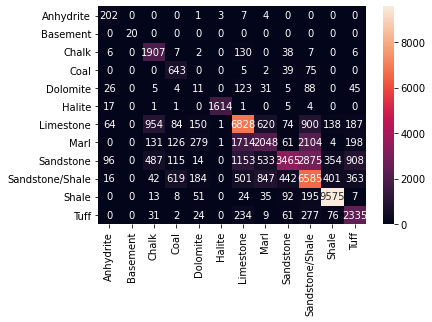

In [67]:
df_partial_data = get_values_from_category(df_train, n_samples=50000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=1000, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='multi_layer'
)

### Test 4

Tuff               10000
Limestone          10000
Chalk              10000
Sandstone/Shale    10000
Shale              10000
Sandstone          10000
Marl               10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayerSoftmax(
  (layer_1): Linear(in_features=30, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
)
Begin training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.81392 | Val Loss: 0.72592 | 
        Train Acc: 71.305% | Val Acc: 75.313%
Epoch 002: | Train Loss: 0.47188 | Val Loss: 0.44653 | 
        Train Acc: 83.281% | Val Acc: 85.124%
Epoch 003: | Train Loss: 0.43232 | Val Loss: 0.39788 | 
        Train Acc: 85.057% | Val Acc: 86.103%
Epoch 004: | Train Loss: 0.41317 | Val Loss: 0.50589 | 
        Train Acc: 85.729% | Val Acc: 82.688%
Epoch 005: | Train Loss: 0.38337 | Val Loss: 0.44978 | 
        Train Acc: 86.998% | Val Acc: 84.337%
Epoch 006: | Train Loss: 0.37718 | Val Loss: 0.37619 | 
        Train Acc: 87.272% | Val Acc: 87.126%
Epoch 007: | Train Loss: 0.36582 | Val Loss: 0.38641 | 
        Train Acc: 87.622% | Val Acc: 86.920%
Epoch 008: | Train Loss: 0.36261 | Val Loss: 0.34329 | 
        Train Acc: 87.899% | Val Acc: 87.517%
Epoch 009: | Train Loss: 0.36561 | Val Loss: 0.35734 | 
        Train Acc: 88.142% | Val Acc: 88.282%
Epoch 010: | Train Loss: 0.35042 | Val Loss: 0.30694 | 
        Train Acc: 88.228%

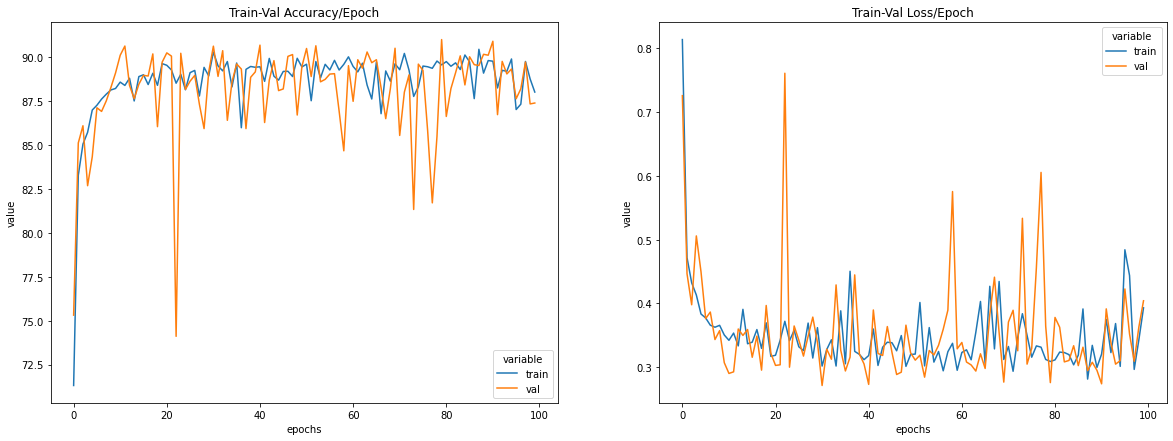

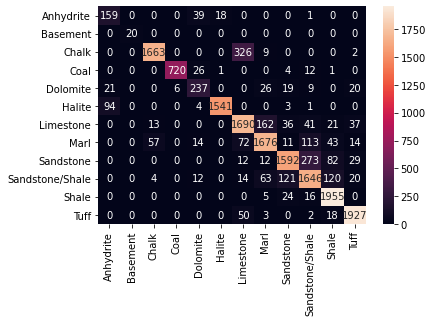

In [71]:
df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=100, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='multi_layer_relu'
)

### Test 5

Chalk              10000
Sandstone          10000
Marl               10000
Tuff               10000
Sandstone/Shale    10000
Limestone          10000
Shale              10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayerReLUBatchNormSoftmax(
  (layer_1): Linear(in_features=30, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.62273 | Val Loss: 0.38134 | 
        Train Acc: 78.677% | Val Acc: 86.655%
Epoch 002: | Train Loss: 0.43224 | Val Loss: 0.30917 | 
        Train Acc: 84.955% | Val Acc: 89.011%
Epoch 003: | Train Loss: 0.39201 | Val Loss: 0.34160 | 
        Train Acc: 86.210% | Val Acc: 87.362%
Epoch 004: | Train Loss: 0.36276 | Val Loss: 0.30866 | 
        Train Acc: 87.366% | Val Acc: 87.333%
Epoch 005: | Train Loss: 0.34308 | Val Loss: 0.28609 | 
        Train Acc: 88.043% | Val Acc: 89.747%
Epoch 006: | Train Loss: 0.33062 | Val Loss: 0.29676 | 
        Train Acc: 88.190% | Val Acc: 88.650%
Epoch 007: | Train Loss: 0.32246 | Val Loss: 0.31139 | 
        Train Acc: 88.551% | Val Acc: 88.172%
Epoch 008: | Train Loss: 0.32145 | Val Loss: 0.26391 | 
        Train Acc: 88.540% | Val Acc: 90.240%
Epoch 009: | Train Loss: 0.30248 | Val Loss: 0.24250 | 
        Train Acc: 89.012% | Val Acc: 90.240%
Epoch 010: | Train Loss: 0.29256 | Val Loss: 0.24212 | 
        Train Acc: 89.514%

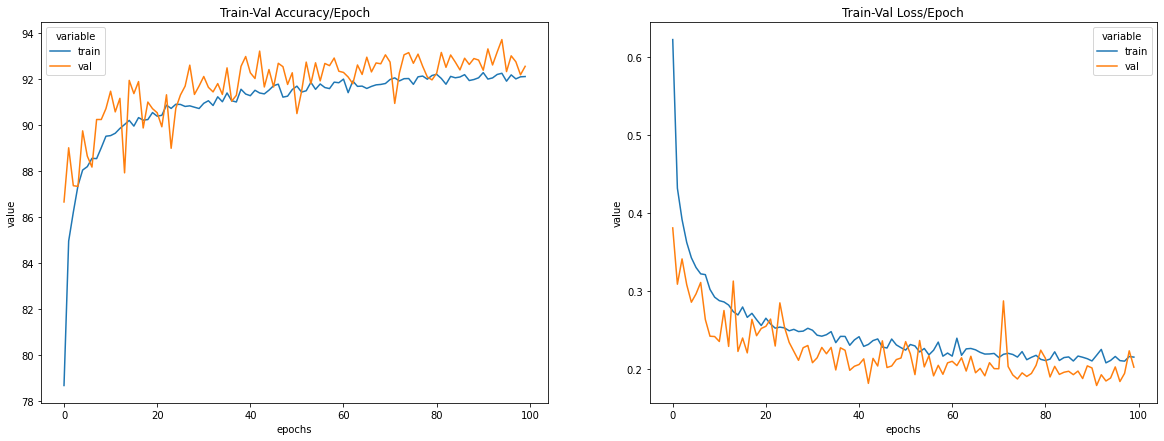

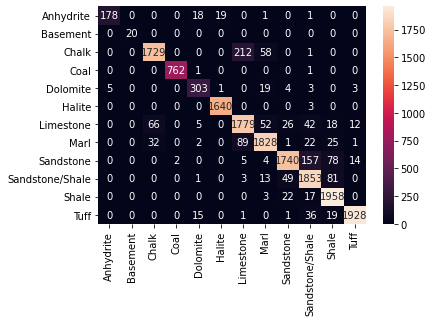

In [15]:
df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

model1 = fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=100, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='multi_layer_relu_batch_norm'
)

### Trying with Augmented Data with SMOTE

The Objective of SMOTE (Synthetic Minority Oversampling Technique) will generate samples of subrepresented classes and may cut some of them that are more representatives.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Test 6

Chalk              10000
Sandstone          10000
Marl               10000
Tuff               10000
Sandstone/Shale    10000
Limestone          10000
Shale              10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayerReLUBatchNormSoftmax(
  (layer_1): Linear(in_features=30, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48323 | Val Loss: 0.29647 | 
        Train Acc: 83.142% | Val Acc: 89.708%
Epoch 002: | Train Loss: 0.35069 | Val Loss: 0.24888 | 
        Train Acc: 87.587% | Val Acc: 90.177%
Epoch 003: | Train Loss: 0.31105 | Val Loss: 0.23814 | 
        Train Acc: 89.030% | Val Acc: 90.755%
Epoch 004: | Train Loss: 0.28974 | Val Loss: 0.21815 | 
        Train Acc: 89.649% | Val Acc: 91.859%
Epoch 005: | Train Loss: 0.27095 | Val Loss: 0.20915 | 
        Train Acc: 90.378% | Val Acc: 92.177%
Epoch 006: | Train Loss: 0.26182 | Val Loss: 0.22013 | 
        Train Acc: 90.609% | Val Acc: 91.693%
Epoch 007: | Train Loss: 0.24914 | Val Loss: 0.21020 | 
        Train Acc: 91.243% | Val Acc: 91.818%
Epoch 008: | Train Loss: 0.24506 | Val Loss: 0.19922 | 
        Train Acc: 91.245% | Val Acc: 92.365%
Epoch 009: | Train Loss: 0.24218 | Val Loss: 0.19261 | 
        Train Acc: 91.349% | Val Acc: 92.750%
Epoch 010: | Train Loss: 0.23507 | Val Loss: 0.18758 | 
        Train Acc: 91.510%

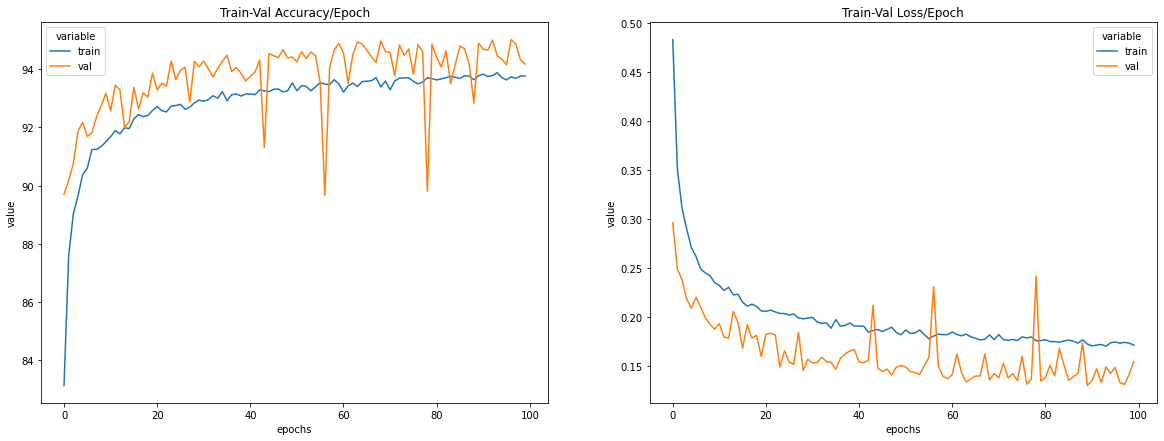

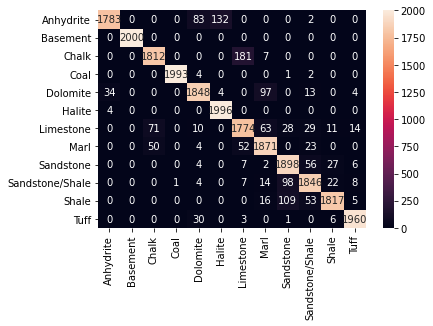

In [13]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

X_balanced, y_balanced = oversample.fit_resample(X, Y)

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X_balanced, y_balanced,
                                                    stratify=y_balanced, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

model = fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=100, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='multi_layer_relu_batch_norm'
)

### Test 8

In [92]:
# Testing with all data
df_partial_data = get_values_from_category(df_train, n_samples=20000)
# df_partial_data = df_train.copy()
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 60:20:20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

model = fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=100, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='multi_layer_relu_batch_norm_dropout'
)

Limestone          20000
Sandstone/Shale    20000
Shale              20000
Sandstone          20000
Marl               20000
Tuff               15245
Chalk              10513
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
MultiLayerReLUBatchNormDropoutSoftmax(
  (layer_1): Linear(in_features=30, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.81030 | Val Loss: 0.48666 | 
        Train Acc: 71.434% | Val Acc: 83.125%
Epoch 002: | Train Loss: 0.53281 | Val Loss: 0.41894 | 
        Train Acc: 80.177% | Val Acc: 85.098%
Epoch 003: | Train Loss: 0.46669 | Val Loss: 0.36191 | 
        Train Acc: 82.250% | Val Acc: 87.293%
Epoch 004: | Train Loss: 0.43642 | Val Loss: 0.34406 | 
        Train Acc: 83.437% | Val Acc: 87.817%
Epoch 005: | Train Loss: 0.40803 | Val Loss: 0.33543 | 
        Train Acc: 84.509% | Val Acc: 88.244%
Epoch 006: | Train Loss: 0.40467 | Val Loss: 0.31336 | 
        Train Acc: 84.679% | Val Acc: 88.581%
Epoch 007: | Train Loss: 0.38270 | Val Loss: 0.30304 | 
        Train Acc: 85.213% | Val Acc: 89.177%
Epoch 008: | Train Loss: 0.37069 | Val Loss: 0.31050 | 
        Train Acc: 85.721% | Val Acc: 88.017%
Epoch 009: | Train Loss: 0.37039 | Val Loss: 0.30483 | 
        Train Acc: 85.627% | Val Acc: 88.799%
Epoch 010: | Train Loss: 0.35724 | Val Loss: 0.28973 | 
        Train Acc: 86.146%

KeyboardInterrupt: 

### Saving Model

In [16]:
def save_model(model, file_name):
    torch.save(model, file_name)

save_model(model1, 'data/model/test_5.pth')